# Plot nitrogen flux maps
Plot Cycles-L predicted nitrogen flux maps at the WE-38 watershed.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.collections import LineCollection
from pihm import read_output
from pihm import read_mesh
from pihm import read_river
from my_funcs import read_cycles
from setting import MS_DIR, CYCLES_DIR

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Define functions

In [3]:
def scale_bar(ax, length,
    location=(0.5, 0.02),
    linewidth=3,
    units='km',
    m_per_unit=1000
    ):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle
    of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    # Get the extent of the plotted area in coordinates in metres
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], color='k', linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.30
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25b2\nN',
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], color='k',
        linewidth=linewidth, zorder=3)

## Plot

Text(0.02, 0.32, '(c)')

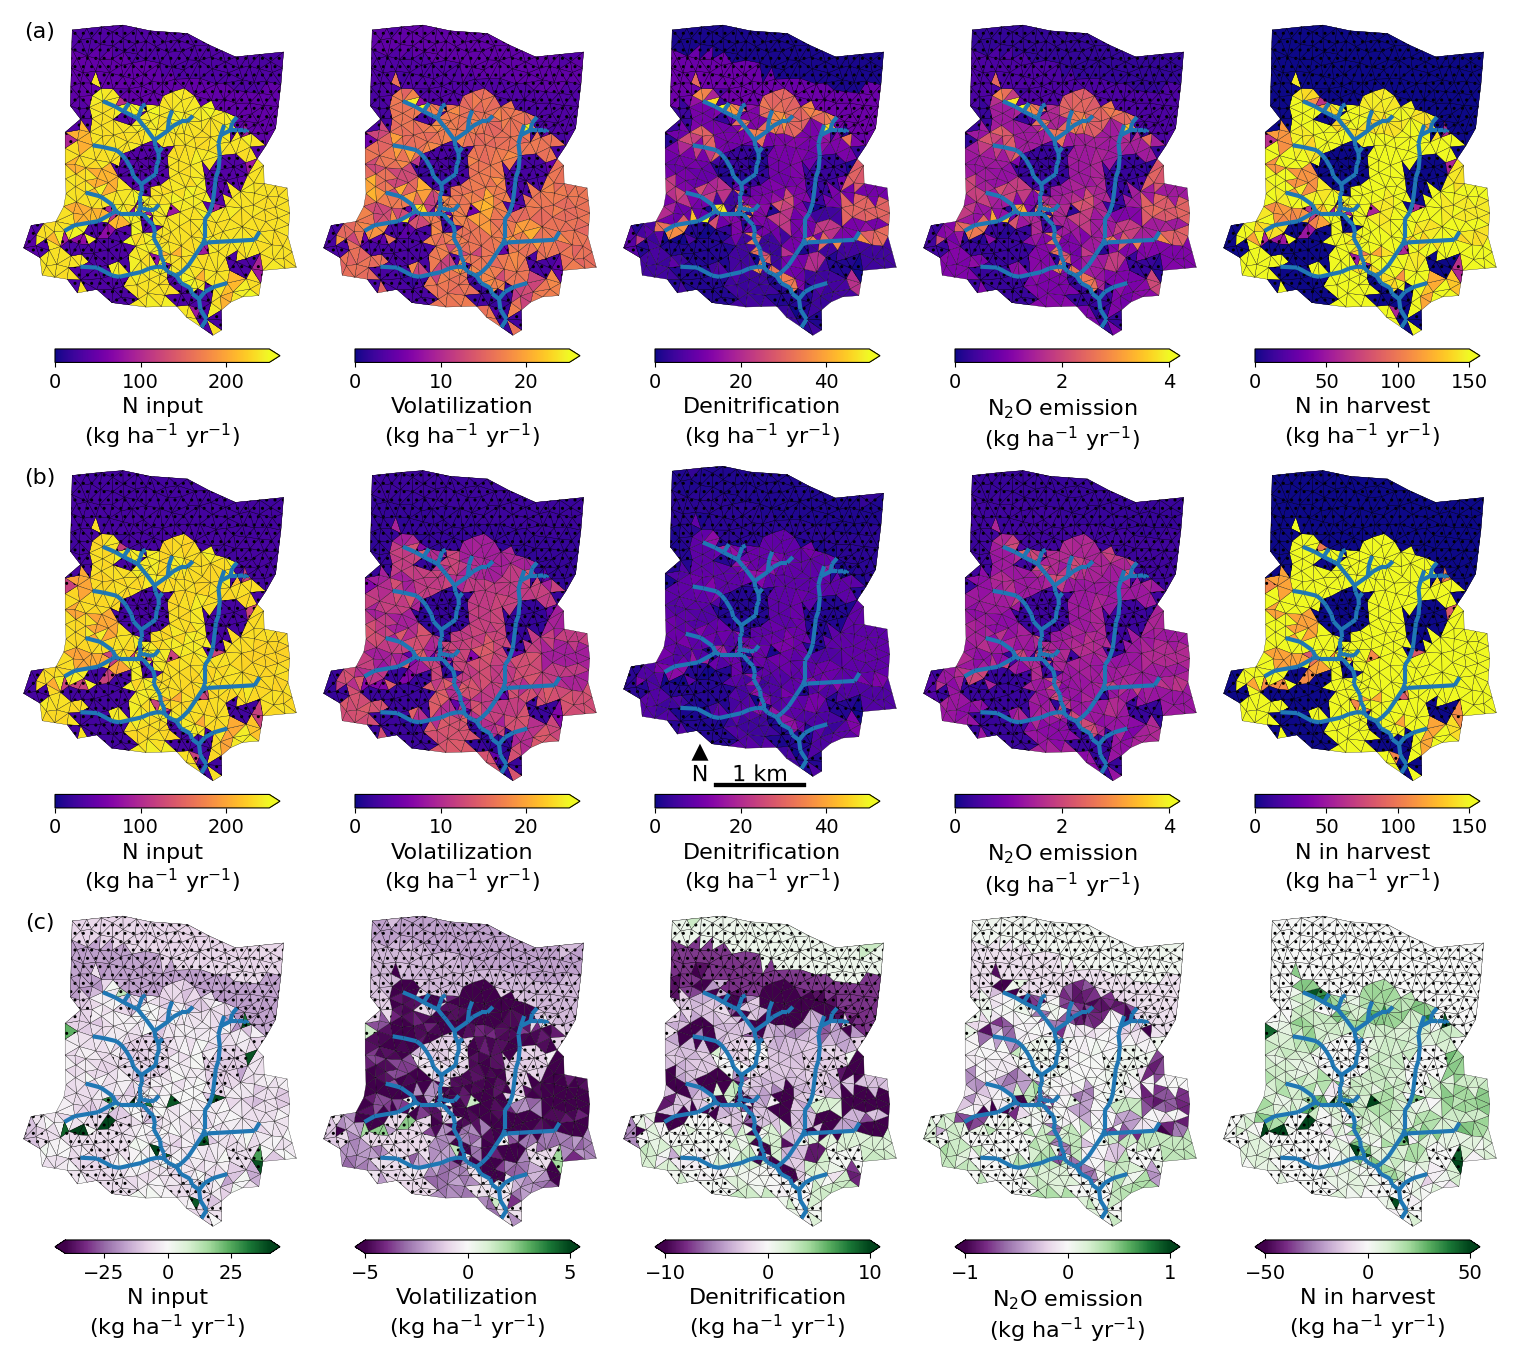

In [4]:
num_elem, _, tri, x, y, _, zmax = read_mesh('..', 'WE38')
num_river, from_node, to_node, _ = read_river('..', 'WE38')
_, mgmt = read_cycles('WE38')

mgmt[(mgmt == 3) | (mgmt == 4) | (mgmt == 5)] = 2
mgmt[(mgmt == 6) | (mgmt == 7)] = 3
mgmt[(mgmt == 8) | (mgmt == 9)] = 4
mgmt[(mgmt == 10)] = 5
mgmt[(mgmt == 11)] = 6

rotations = [
    'Forest',
    'Corn (2)-Soy-Corn-Hay (4)',
    'Corn (4)-Hay (4)',
    'Soy-Corn',
    'Hay',
    'Corn-Soy-Corn-Soy-Oat Hay-Hay (3)',
]

simulation = 'WE38_1dot25xN'
_, _n_auto, _, _ = read_output('..', 'WE38', simulation, 'n_auto')
_, _n_fix, _, _ = read_output('..', 'WE38', simulation, 'n_fix')
_, _n_fert, _, _ = read_output('..', 'WE38', simulation, 'n_fert')
_, _denitrif, _, _ = read_output('..', 'WE38', simulation, 'denitrif')
_, _n_harvest, _, _ = read_output('..', 'WE38', simulation, 'n_harvest')
_, _n_volatil, _, _ = read_output('..', 'WE38', simulation, 'volatil')
_, _n2o_denitrif, _, _ = read_output('..', 'WE38', simulation, 'n2o_denitrif')
_, _n2o_nitrif, _, _ = read_output('..', 'WE38', simulation, 'n2o_nitrif')

# Plot Cycles fluxes
df = pd.read_csv(
    f'{CYCLES_DIR}/average_n_fluxes_1.25xN.csv',
    index_col=0,
)

nfluxes = {}

rows = ["Cycles-L", "Cycles", "diff"]
fluxes = ["input", "volatil", "denitrif", "n2o", "harvest"]

ybot = [0.71, 0.38, 0.05]
pad = 0.025
height = 0.32
width = 0.2
cb_width = 0.15
cb_height = 0.01

nfluxes["input"] = {
    "Cycles-L": np.average(_n_fert + _n_auto + _n_fix, axis=0) * 1000 * 365,
    "Cycles": df['fertilization'] + df['auto_added'] + df['fixation'],
    "diff": df['fertilization'] + df['auto_added'] + df['fixation'] - np.average(_n_fert + _n_auto + _n_fix, axis=0) * 1000 * 365,
    "name": "N input",
    "axis": lambda row: [0.0, ybot[row], width, height],
    "cba": lambda row: [0.03, ybot[row] + pad, cb_width, cb_height],
    "zmax": [250, 250, 40],
}
nfluxes["denitrif"] = {
    "Cycles-L": np.average(_denitrif, axis=0) * 1000 * 365,
    "Cycles": df['denitrification'],
    "diff": df['denitrification'] - np.average(_denitrif, axis=0) * 1000 * 365,
    "name": "Denitrification",
    "axis": lambda row: [0.4, ybot[row], width, height],
    "cba": lambda row: [0.43, ybot[row] + pad, cb_width, cb_height],
    "zmax": [50, 50, 10],
}
nfluxes["harvest"] = {
    "Cycles-L": np.average(_n_harvest, axis=0) * 1000 * 365,
    "Cycles": df['n_in_harvest'],
    "diff": df['n_in_harvest'] - np.average(_n_harvest, axis=0) * 1000 * 365,
    "name": "N in harvest",
    "axis": lambda row: [0.8, ybot[row], width, height],
    "cba": lambda row: [0.83, ybot[row] + pad, cb_width, cb_height],
    "zmax": [150, 150, 50],
}
nfluxes["volatil"] = {
    "Cycles-L": np.average(_n_volatil, axis=0) * 1000 * 365,
    "Cycles": df['volatilization'],
    "diff": df['volatilization'] - np.average(_n_volatil, axis=0) * 1000 * 365,
    "name": "Volatilization",
    "axis": lambda row: [0.2, ybot[row], width, height],
    "cba": lambda row: [0.23, ybot[row] + pad, cb_width, cb_height],
    "zmax": [25, 25, 5],
}
nfluxes["n2o"] = {
    "Cycles-L": np.average(_n2o_denitrif + _n2o_nitrif, axis=0) * 1000 * 365,
    "Cycles": df['n2o_emission'],
    "diff": df['n2o_emission'] - np.average(_n2o_denitrif + _n2o_nitrif, axis=0) * 1000 * 365,
    "name": "N$_2$O emission",
    "axis": lambda row: [0.6, ybot[row], width, height],
    "cba": lambda row: [0.63, ybot[row] + pad, cb_width, cb_height],
    "zmax": [4, 4, 1],
}

xc = []
yc = []
for ielem in range(num_elem):
    xc.append(np.mean(x[tri[ielem][:]]))
    yc.append(np.mean(y[tri[ielem][:]]))

river_xc = []
river_yc = []
for iriver in range(num_river):
    river_xc.append(np.mean(x[[from_node[iriver], to_node[iriver]]]))
    river_yc.append(np.mean(y[[from_node[iriver], to_node[iriver]]]))

# Create line collection of river segments for plotting
lines = [[(x[from_node[i]], y[from_node[i]]), (x[to_node[i]], y[to_node[i]])] for i in range(num_river)]

fig = plt.figure(figsize=(15, 13.5))

for idx, row in enumerate(rows):
    cmap = "PRGn" if row == "diff" else "plasma"

    for ind, f in enumerate(fluxes):
        vmin = -nfluxes[f]["zmax"][idx] if row == "diff" else 0
        vmax = nfluxes[f]["zmax"][idx]

        ax = fig.add_axes(nfluxes[f]["axis"](idx))
        tpc = ax.tripcolor(x, y, tri,
            facecolors=nfluxes[f][row],
            edgecolors='k',
            lw=0.2,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
        )
        ax.tripcolor(x, y, tri[(mgmt == 1) | (mgmt == 5)],
            facecolors=nfluxes[f][row][(mgmt == 1) | (mgmt == 5)],
            edgecolors='k',
            hatch='..',
            lw=0.2,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
        )
        if idx == 1 and ind == 2: scale_bar(ax, 1)
        cbaxes = fig.add_axes(nfluxes[f]["cba"](idx))
        cbar = plt.colorbar(
            tpc,
            shrink=5/7,
            cax=cbaxes,
            orientation="horizontal",
            extend="both" if row == "diff" else "max",
        )

        cbar.set_label(label="%s\n(kg ha$^{-1}$ yr$^{-1}$)" % (nfluxes[f]["name"]))

        river_segments = LineCollection(lines,
            linewidths=3,
            colors='tab:blue',
            linestyle='solid',
        )

        ax.add_collection(river_segments)
        ax.set_aspect('equal')
        ax.axis('off')


fig.text(0.02, 0.98,'(a)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.02, 0.65,'(b)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.02, 0.32,'(c)', ha='center', va='center', transform=fig.transFigure)


In [5]:
fig.savefig(f'{MS_DIR}/latex/nfluxes.pdf', dpi=300)
fig.savefig(f'{MS_DIR}/figures/nfluxes.png', dpi=300)